# The Terrestrial Microwave Window (The Water Hole)

This notebook explains why the Search for Extraterrestrial Intelligence (SETI) has focused on searching for radio signals in a specific range of frequencies.  

If you're searching for a radio signal from an extraterrestrial intelligence (ETI), it makes sense to search at frequencies:

 1. where the Universe is emitting less photons (particles of light)
 2. where your instrument is emitting less photons, and
 3. where the atmosphere is transparent to photons.

If you're searching for radio signals using a ground-based telescope, then there are only a small range of frequencies that are quiet/clear enough to search.  Let's explore!


In [85]:
# setup the plotting


import numpy as np
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 18})


T_min = 1.0
T_max = 1.0e3

First, let's decide the frequency range we're interested in.  We'll be looking in the GHz range:

In [96]:
freq_min = 0.1e9  # Hz
freq_max = 100.0e9 # Hz

freq_min = np.log10(freq_min)
freq_max = np.log10(freq_max)

nfreq = 100 

freq = np.logspace(freq_min,freq_max, num=nfreq)

freqGHz = freq/1.0e9 # frequency in GHz


def setup_figure():
    fig1 = plt.figure(figsize=(16,8))
    ax1 = fig1.add_subplot(111)
    ax1.set_xlabel('Frequency (GHz)')
    ax1.set_ylabel('Intensity (Kelvin)')
    ax1.set_xscale('log')
    ax1.set_yscale('log')


    ax1.set_ylim(T_min,T_max)

    return ax1, fig1
    


## Observing ETIs in the Radio From Space - The Vacuum Microwave Window

Let's start by assuming we're above the Earth's atmosphere.  We'll be calculating the intensity of radiation measured at our radio telescope due to "natural" radiation, as well as noise effects on our telescope.  We'll be measuring this in terms of a [brightness temperature](https://en.wikipedia.org/wiki/Brightness_temperature), which is common practice in radio astronomy.  All we need to remember is that high brightness temperature means more photons getting in the way of our alien's radio signal.

At low frequencies, the Galaxy emits large amounts of synchrotron radiation, which is produced by electrons orbiting the Galaxy's magnetic field.  This produces a non-thermal spectrum of radiation which is described by the following powerlaw in frequency $f$ (Mozdzen et al MNRAS 2016, http://adsabs.harvard.edu/cgi-bin/bib_query?arXiv:1609.08705):

$ T_{\rm synchrotron} = 300 \left(\frac{f}{150\,\rm{MHz}}\right)^{-2.6}$

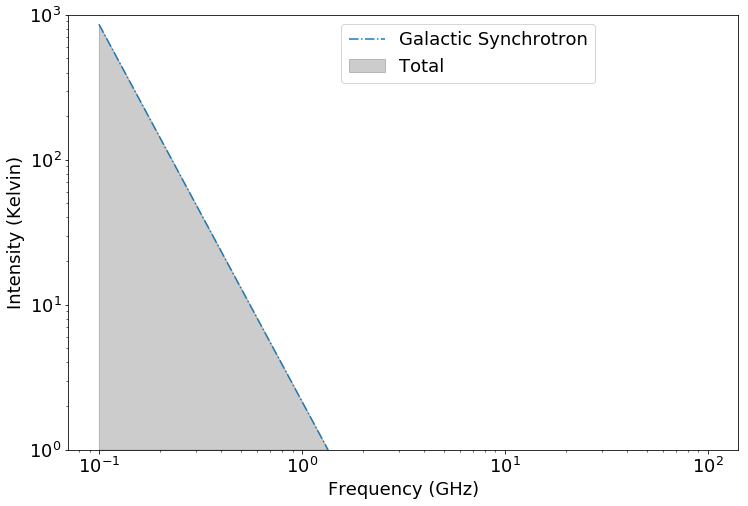

In [114]:
synchrotron = 300.0*pow(freq/150.0e6,-2.6)

total = synchrotron

ax1,fig1 = setup_figure()

ax1.plot(freqGHz,synchrotron, linestyle='-.',label='Galactic Synchrotron')
ax1.fill_between(freqGHz, total,T_min, where=total>T_min, label = 'Total', color='black', alpha=0.2)
ax1.legend(loc='upper right',bbox_to_anchor=(0.8,1.0), fontsize=18)

This synchrotron radiation will be observed by pretty much any alien living in our Galaxy, so at low frequencies it's unlikely they will want to transmit through all that radiation.  At higher frequencies, there are instrumental limitations imposed by quantum mechanics, and the fact that we are trying to observe individual particles of light.  This results in a brightness temperature at our telescope:

$T_{\rm shot} = \frac{hf}{k_B}$

Where $h$ is Planck's constant, and $k_B$ is the Boltzmann constant.  This phenomenon is sometimes called [shot noise](https://en.wikipedia.org/wiki/Shot_noise).  

We should also consider the *cosmic microwave background* - the light emitted by the Universe shortly after the Big Bang, when the Universe became transparent.  This corresponds to a blackbody of temperature $T_{CMB} = 2.725K$, which sets a noise floor for our observations. Strictly, we should calculate the full blackbody spectrum at $T_{CMB}$ and then derive the brightness temperature from that, but as we are in the Rayleigh-Jeans regime it's equivalent to setting $T=T_{CMB}$.

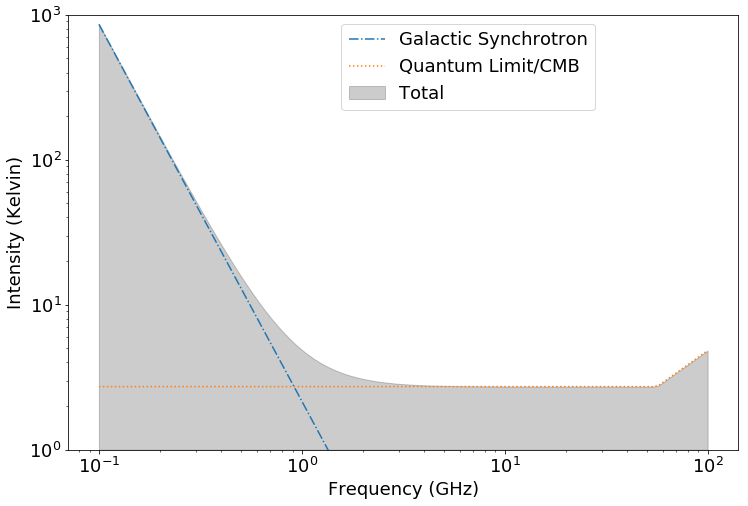

In [115]:
h = 6.67e-34 # Planck's constant
k_B = 1.38e-23 # Boltzmann constant
c = 2.99e10 # speed of light
T_CMB = 2.725 # Cosmic Microwave Background temperature

shotnoise = h*freq/k_B #

shotnoise[shotnoise<T_CMB] = T_CMB

total = synchrotron + shotnoise

ax1, fig1 = setup_figure()

ax1.plot(freqGHz,synchrotron, linestyle='-.',label='Galactic Synchrotron')
ax1.plot(freqGHz,shotnoise, linestyle=':', label='Quantum Limit/CMB')
ax1.fill_between(freqGHz, total,T_min, where=total>T_min, label = 'Total', color='black', alpha=0.2)
ax1.legend(loc='upper right',bbox_to_anchor=(0.8,1.0), fontsize=18)

This is the vacuum microwave window.  If you're in our Galaxy, using a space telescope, then you can transmit or listen to radio signals wherever the total curve stays low (shaded area).

## Observing ETIs from Earth: The Terrestrial Microwave Window

But what about ground-based telescopes? Then, we need to worry about atmospheric absorption.  Generally speaking, the majority of absorption occurs due to oxygen ($O_2$) and water ($H_2O$) molecules.  We can think of our atmosphere like a *grey body* - a black body that only partially absorbs the light that impinges on it.  Because we are at long enough wavelengths, we can calculate the sky noise temperature if we know its optical depth, $\tau$:

$T_{\rm sky} = T_{\rm atmosphere}(1- e^{-\tau})$

Where $\tau$ is the atmospheric optical depth.  In this example, I've generated the transmittance spectrum $T_r$ from the [Planetary Spectrum Generator](https://psg.gsfc.nasa.gov/index.php), and

$T_r = e^{-\tau}$

(Note - the current dataset only goes down to 3 GHz, but there isn't anything of interest in the spectrum below this value)

In [116]:
# Load atmosphere optical depth data from Planetary Spectrum Generator (file included)

atmosdata = np.genfromtxt('atmosphere_wet.txt', skip_header=13)

freqtau = atmosdata[:,0][atmosdata[:,1]<1.0]
freqtau = freqtau*1e9
transmittance = atmosdata[:,1][atmosdata[:,1]<1.0]

# Data in descending frequency order - flip both arrays

freqtau = np.flip(freqtau,0)
transmittance = np.flip(transmittance,0)

# Interpolate atmospheric data onto same frequency range

transmit_interp = np.interp(freq, freqtau, transmittance)


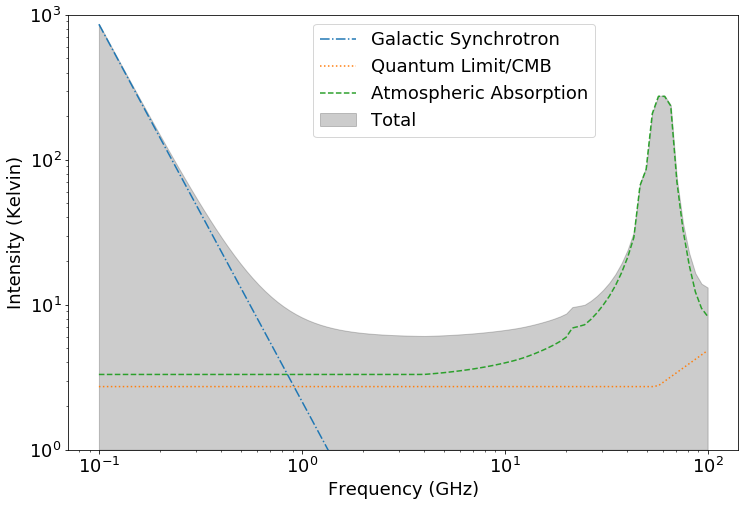

In [117]:
# Compute sky noise temperature

T_atm = 274.0 # Atmosphere temperature (defined by generated spectrum)

sky = T_atm *(1.0-transmit_interp)

# Remake plot

total = synchrotron + shotnoise + sky

ax1, fig1 = setup_figure()

ax1.plot(freq/1.0e9,synchrotron, linestyle='-.',label='Galactic Synchrotron')
ax1.plot(freq/1.0e9,shotnoise, linestyle=':', label='Quantum Limit/CMB')
ax1.plot(freq/1.0e9,sky, linestyle='dashed', label='Atmospheric Absorption')
ax1.fill_between(freq/1.0e9, total,T_min, where=total>T_min, label = 'Total', color='black', alpha=0.2)

ax1.legend(loc='upper right',bbox_to_anchor=(0.8,1.0), fontsize=18)

So we can see that between about 1 GHz and 10 GHz, we have quite good observing conditions from the ground.  The Galaxy is relatively quiet, and Earth's atmosphere isn't absorbing too many photons.

So what's to see in this region of frequencies? There are two spectral lines of considerable interest to astronomers.  The first line is at the hydrogen line ($f_H =1.42$ GHz).  This is emitted by hydrogen atoms, which consist of a proton and an electron.  Each has its own quantum property called *spin*.  The proton-electron spins can either be aligned or anti-aligned.  When the spins flip from aligned to anti-aligned, the atom emits a photon with frequency $f_H$.  Hydrogen is the most common element in the Universe, and the hydrogen line has become extremely important for astronomers mapping the visible matter in galaxies.  It's not unreasonable to assume alien astronomers would be interested in hydrogen as well, and would be scanning the Universe around this frequency.

The second spectral line is at $f_{OH} = 1.61$ GHz, and is produced by the hydroxyl radical (OH).  If you add 

$H + OH \rightarrow H_2O$

Then we have water - an essential ingredient for life (and intelligent life) on Earth. 

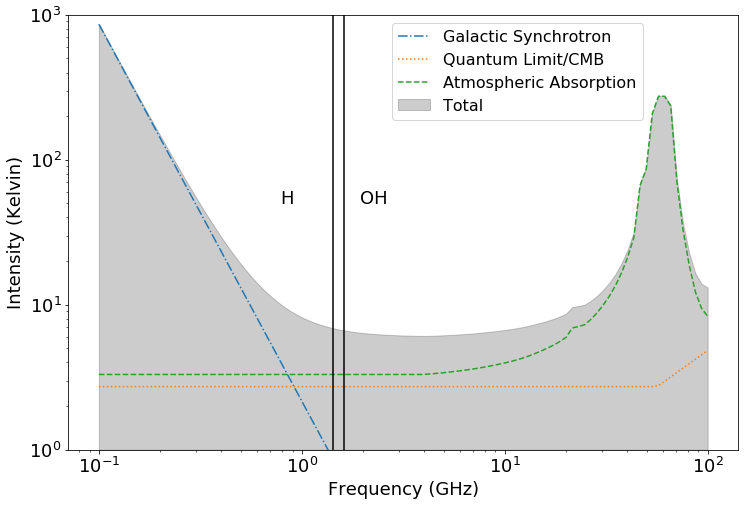

In [121]:
line_H = 1.42
line_OH = 1.61 # in GHz


ax1,fig1= setup_figure()

ax1.plot(freq/1.0e9,synchrotron, linestyle='-.',label='Galactic Synchrotron')
ax1.plot(freq/1.0e9,shotnoise, linestyle=':', label='Quantum Limit/CMB')
ax1.plot(freq/1.0e9,sky, linestyle='--', label='Atmospheric Absorption')
ax1.fill_between(freq/1.0e9, total,T_min, where=total>T_min, label = 'Total', color='black', alpha=0.2)
ax1.axvline(line_H, color='black')
ax1.text(line_H*0.55, 50.0, 'H')

ax1.axvline(line_OH, color='black')
ax1.text(line_OH*1.2, 50.0, 'OH')


ax1.legend(loc='upper right',bbox_to_anchor=(0.87,1.0), fontsize=16)

fig1.savefig('waterhole.png', dpi=300)

This is why we often see this referred to as "The Water Hole".  It's a hole in the spectrum where the constituents of water emit lines.  In the colloquial sense, it could also be a place where many species gather, just like the watering holes of Earth.

If aliens use the H line as a base, they may want to use a related but different frequency, e.g. twice the H line frequency, to allow communication without polluting a valuable frequency for astronomy.  We do something similar on Earth by preventing the use of specific radio frequencies for communications.

This is why so many searches for extraterrestrial intelligence have been carried out at around 1.4 GHz or 2.8 GHz.  But what about $\pi f_H$? Or $2\pi f_H$?  In practice, we have [many possible choices](http://adsabs.harvard.edu/abs/1993A%26A...278..669B) for a search frequency, given a base spectral line:

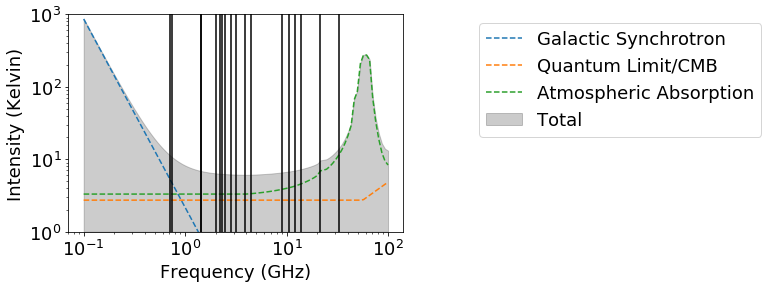

In [92]:
# Example scalings of H line from Blair & Zadnik (1993)

line_choices = [0.5, np.pi/6,np.pi,0.9986,1.001,np.sqrt(2),np.pi/2.0,1.618,np.sqrt(3),1.9990,np.sqrt(5),np.e,2*np.pi,np.e*np.e,np.e*np.pi,np.pi*np.pi,np.exp(np.e),np.exp(np.pi)]

lines_H = [i*line_H for i in line_choices]

fig1 = plt.figure()
ax1 = fig1.add_subplot(111)
ax1.set_xlabel('Frequency (GHz)')
ax1.set_ylabel('Intensity (Kelvin)')
ax1.set_xscale('log')
ax1.set_yscale('log')

ax1.set_ylim(T_min,T_max)

ax1.plot(freq/1.0e9,synchrotron, linestyle='dashed',label='Galactic Synchrotron')
ax1.plot(freq/1.0e9,shotnoise, linestyle='dashed', label='Quantum Limit/CMB')
ax1.plot(freq/1.0e9,sky, linestyle='dashed', label='Atmospheric Absorption')
ax1.fill_between(freq/1.0e9, total,T_min, where=total>T_min, label = 'Total', color='black', alpha=0.2)
[ax1.axvline(line, color='black') for line in lines]

ax1.legend(bbox_to_anchor=(1.2, 1.0))

And that's just for the hydrogen line.  If we add multiples of the OH line as well:

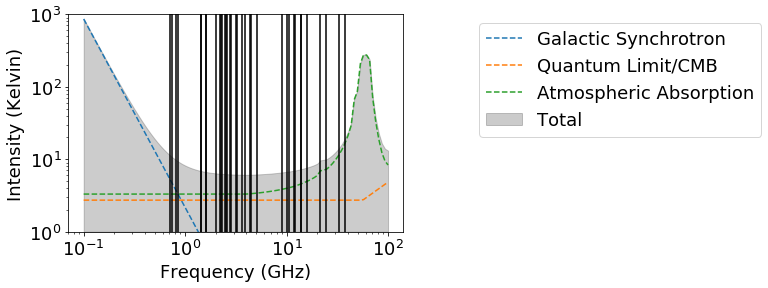

In [93]:

lines_OH = [i*line_OH for i in line_choices]

fig1 = plt.figure()
ax1 = fig1.add_subplot(111)
ax1.set_xlabel('Frequency (GHz)')
ax1.set_ylabel('Intensity (Kelvin)')
ax1.set_xscale('log')
ax1.set_yscale('log')

ax1.set_ylim(T_min,T_max)

ax1.plot(freq/1.0e9,synchrotron, linestyle='dashed',label='Galactic Synchrotron')
ax1.plot(freq/1.0e9,shotnoise, linestyle='dashed', label='Quantum Limit/CMB')
ax1.plot(freq/1.0e9,sky, linestyle='dashed', label='Atmospheric Absorption')
ax1.fill_between(freq/1.0e9, total,T_min, where=total>T_min, label = 'Total', color='black', alpha=0.2)
[ax1.axvline(line, color='black') for line in lines_H]
[ax1.axvline(line, color='black') for line in lines_OH]

ax1.legend(bbox_to_anchor=(1.2, 1.0))

There are still many frequencies for ETIs to choose to broadcast on.  This is why modern SETI searches scan essentially every frequency in the microwave window, rather than relying on a single line.